In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from qnetwork.dde import DDE_analytical
from qnetwork.multiphoton_ww import EmittersInWaveguideMultiphotonWW
from qnetwork.tools import set_plot_style

set_plot_style()

In this notebook, we plot the graphs regarding the discountinuos nature of the dynamics in the many-mode regime. 

In [6]:
gamma=0.04
phi=10*np.pi
L=1
c=1.2
tau=2*L/c

FSR = 2*np.pi / tau


positions=[0.0]
Delta=[phi/(2*np.pi)]
setup = EmittersInWaveguideMultiphotonWW(positions=positions,gamma=gamma,Delta=Delta,L=L,c=c)

In [7]:
t_max = 20
t,e=setup.evolve(t_max,initial_state="1")
e2 = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)

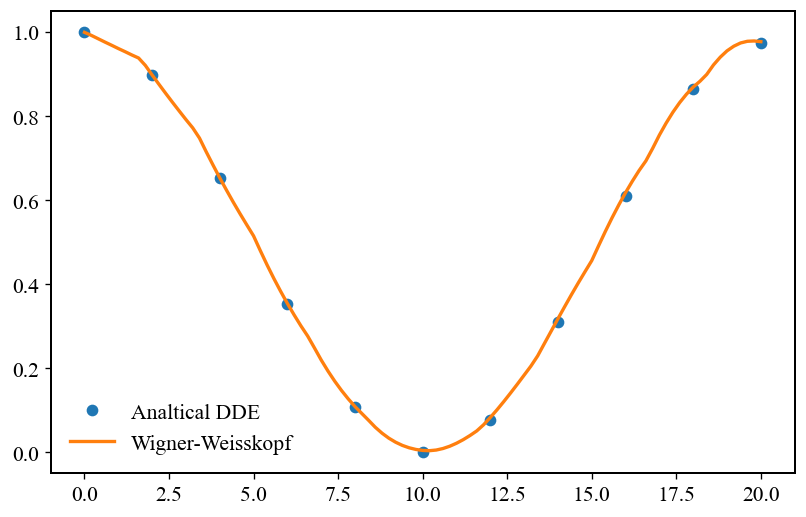

In [8]:
plt.plot(t,e2,'o',markevery=10,label='Analtical DDE ')
plt.plot(t,e,label='Wigner-Weisskopf')
plt.legend()
plt.grid()
plt.show()